In [1]:
# UFRJ/POLI/DEL - Processamento de Sinais de Audio - 2019.1
# Professor: Luiz Wagner Pereira Biscainho
# Exercicio 19 - Curvas de Mascaramento
# Grupo 1: Maria Gabriella Felgas, Matheus Moreno e Miguel de Sousa
  
from scipy import signal
from scipy.io import wavfile

import numpy as np

import matplotlib.pyplot as plt

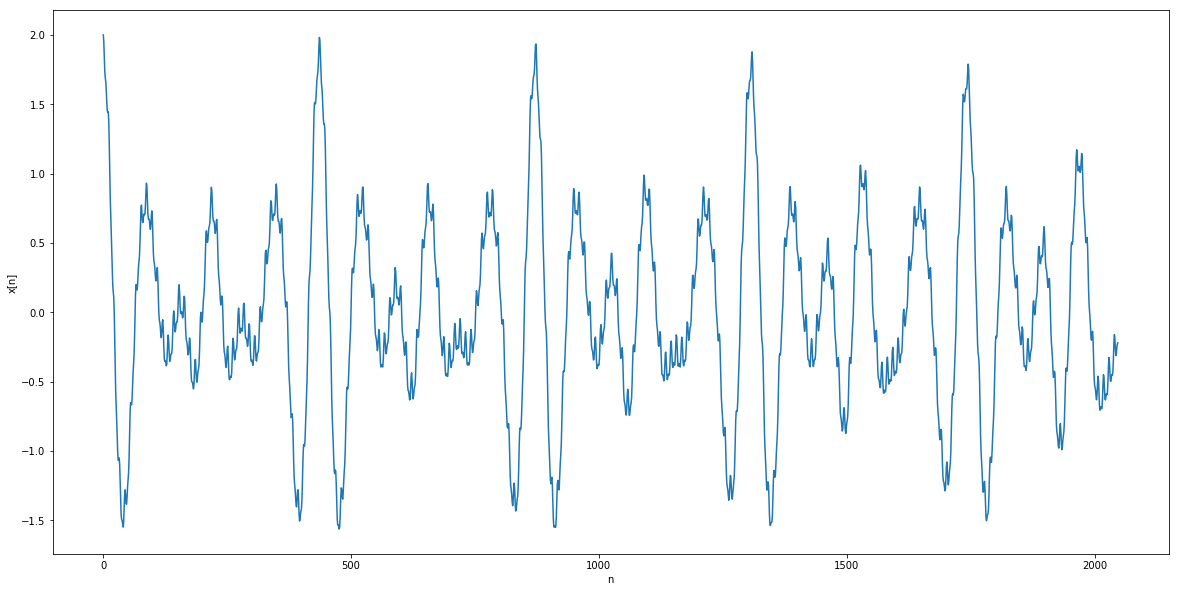

In [2]:
# Definindo as variaveis iniciais

fs = 48000

f0 = 440
f1 = 554
f2 = 660
f3 = 880
f4 = 4400
f5 = 8800

A0 = 0.6
A1 = 0.55
A2 = 0.55
A3 = 0.15
A4 = 0.1
A5 = 0.05

# n variando de 0 a 2048
n = [i for i in range(2048)]
nfft = len(n)

# Definindo as frequencias
freqmax = fs
freqmin = 0

freqhop = (freqmax - freqmin)/nfft


# O sinal de teste, x, eh um combinacao de cosenoides de diferentes periodos
x = np.multiply(A0, np.cos(np.multiply(2*(np.pi)*f0/fs, n))) + np.multiply(A1, np.cos(np.multiply(2*(np.pi)*f1/fs, n))) \
    + np.multiply(A2, np.cos(np.multiply(2*(np.pi)*f2/fs, n))) + np.multiply(A3, np.cos(np.multiply(2*(np.pi)*f3/fs, n))) \
    + np.multiply(A4, np.cos(np.multiply(2*(np.pi)*f4/fs, n))) + np.multiply(A5, np.cos(np.multiply(2*(np.pi)*f5/fs, n)))

plt.figure(figsize=(20,10))
plt.plot(n, x)
plt.ylabel('x[n]')
plt.xlabel('n')
plt.show()

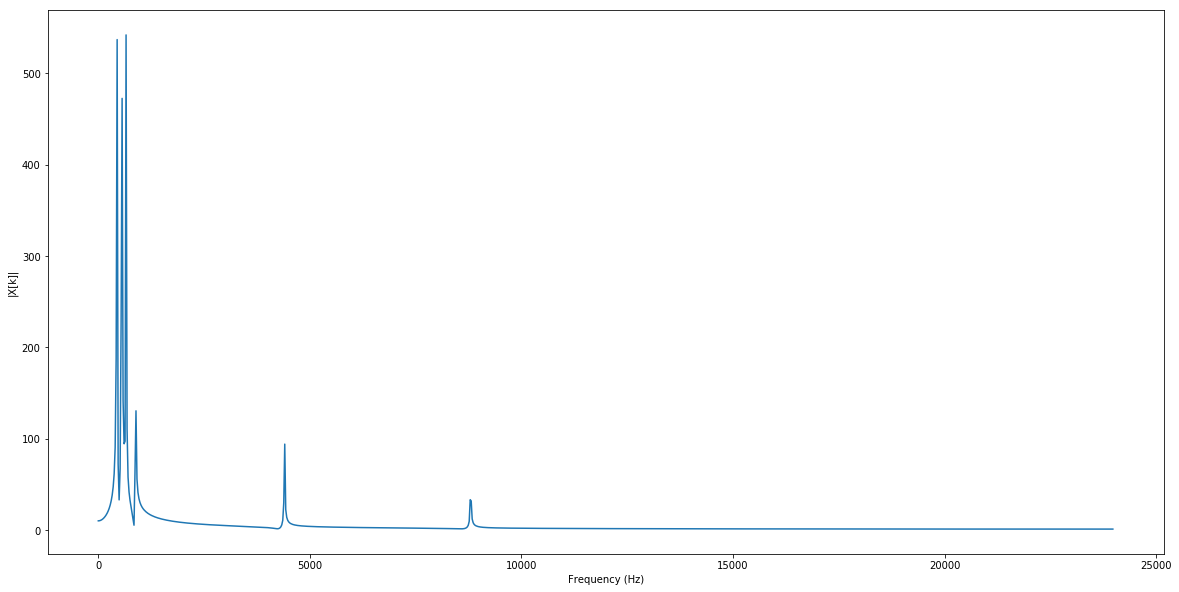

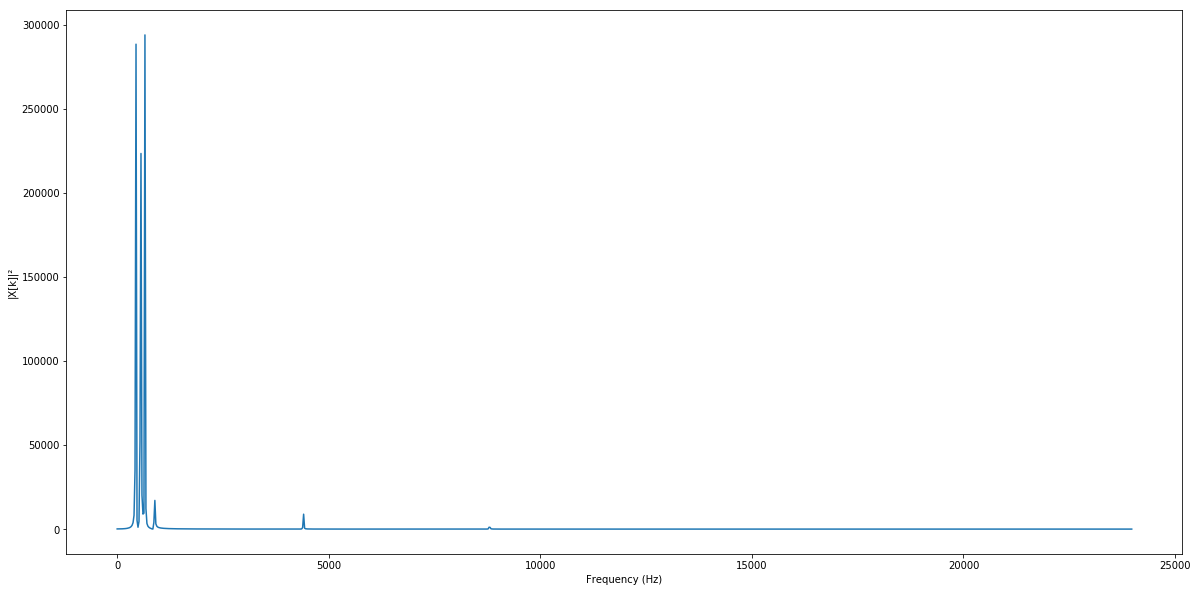

In [3]:
# Realizamos a FFT de x e avaliamos seus valores absolutos

freq = np.dot(freqhop, n)

x_fft = np.fft.fft(x)

# Truncando os sinais, para considerar somente a parte positiva do espectro,
# ou seja, somente as "frequencias positivas" de cada cossenoide
freq = freq[:-1024]
x_fft = x_fft[:-1024]

plt.figure(figsize=(20,10))
plt.plot(freq, abs(x_fft))
plt.ylabel('|X[k]|')
plt.xlabel('Frequency (Hz)')
plt.show()


# Depois, realizamos o calculo do modulo ao quadrado da FFT

x_fft_2 = abs(x_fft) ** 2

plt.figure(figsize=(20,10))
plt.plot(freq, x_fft_2)
plt.ylabel('|X[k]|²')
plt.xlabel('Frequency (Hz)')
plt.show()

In [4]:
# Encontramos os picos da FFT
peaks, _ = signal.find_peaks(x_fft_2)

print(freq[peaks])


# Definimos a funcao de transformacao de dominios da frequencia (FFT)
# para dominio Bark  e vice-versa (utilizamos a aproximacao de
# Wang, Sekey, Gersho (1992))

def freq2bark(freq):

    bark = 6 * np.arcsinh(freq / 600)
    
    return bark

def bark2freq(bark):

    freq = 600 * np.sinh(bark / 6)
    return freq


# Definimos a funcao de transformacao para SPL, em dB

def amp2spl(x_fft_2):
    
    w_2 = 1 # A janela considerada foi a retangular, ou seja, de peso 1
        
    SPL = 96 + np.dot(10, np.log10(np.dot((4 / ((nfft ** 2) * w_2)), x_fft_2)))
    
    return SPL

[ 445.3125  562.5     656.25    890.625  4406.25   8789.0625]


[ 4.12131275  5.01889121  5.67681707  7.11638795 16.14960281 20.27186345]


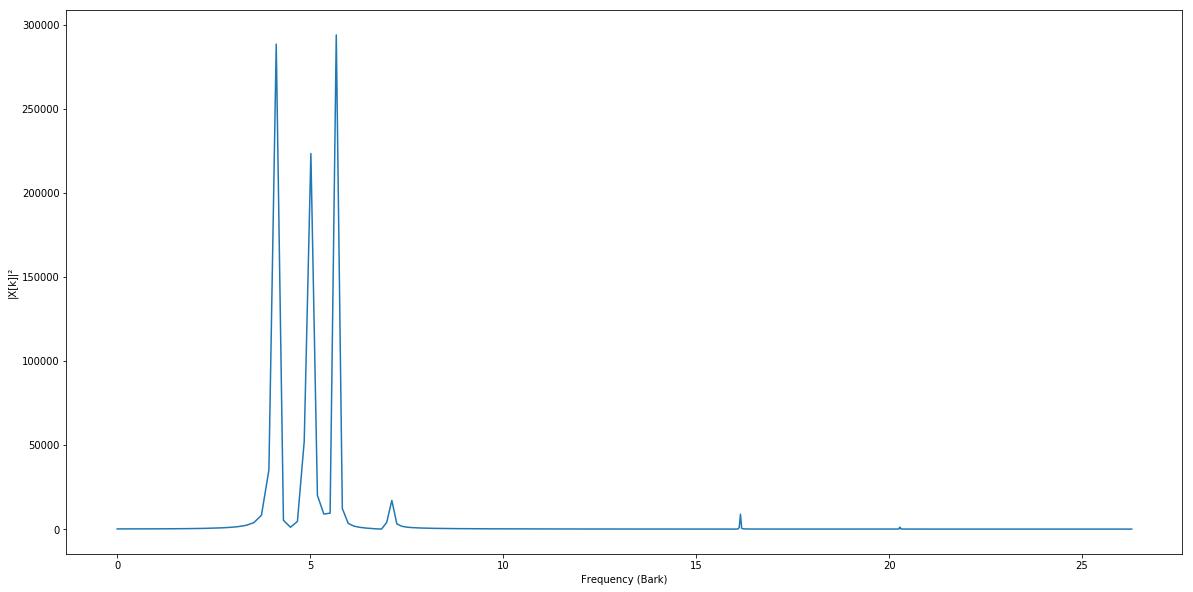

In [5]:
# Realizamos a transformacao de dominios

bark = freq2bark(freq)

print(bark[peaks])

plt.figure(figsize=(20,10))
plt.plot(bark, x_fft_2)
plt.ylabel('|X[k]|²')
plt.xlabel('Frequency (Bark)')
plt.show()

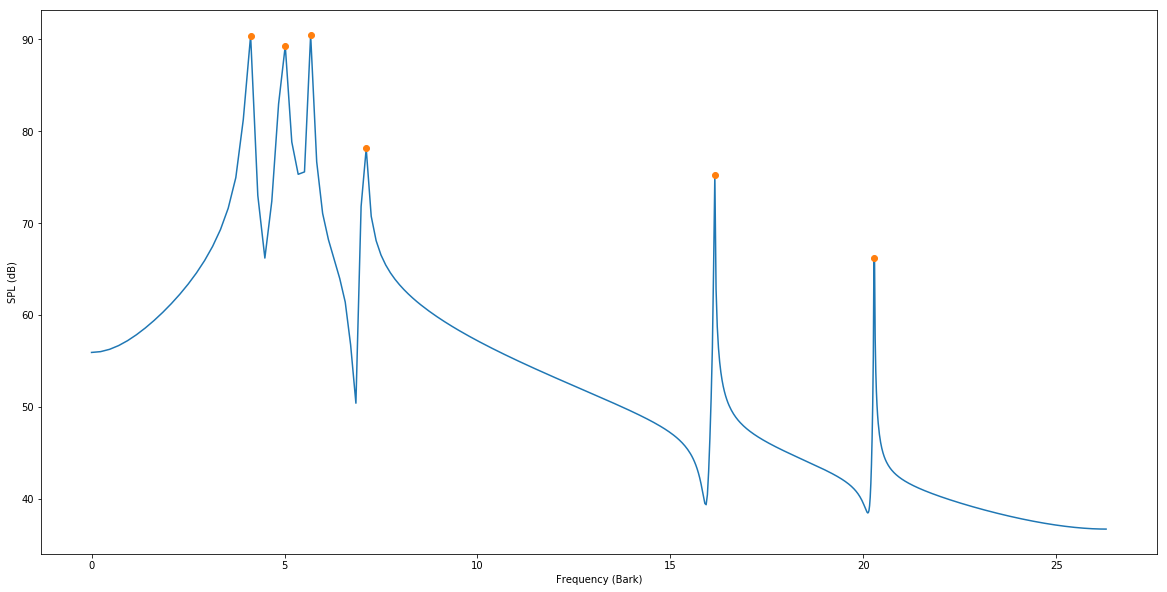

In [6]:
# E a transformacao de escalas

SPL = amp2spl(x_fft_2)


plt.figure(figsize=(20,10))
plt.plot(bark, SPL)
plt.plot(bark[peaks], SPL[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

In [7]:
# Definimos as spreading functions

def spreading_function(bark, SPL, peaks, down_shift):
    
    sf = np.zeros(len(bark))
    sf_peaks = np.zeros((len(bark), len(bark)))
    
    for i in peaks:
        
        for j in range(len(bark)):
            
            dz = bark[j] - bark[i]

            if dz < 0:
                teta = 0
            else:
                teta = 1 

            sf[j] = ((-27 + 0.37 * max((SPL[i] - 40), 0) * teta) * abs(dz))
                
        sf_peaks[i] = SPL[i] - down_shift + sf
        
                
    return sf_peaks

In [8]:
# E aplicamos aos picos de acordo com seus espalhamentos

sf_peaks_1 = spreading_function(bark, SPL, peaks, down_shift=0)
sf_peaks_2 = spreading_function(bark, SPL, peaks, down_shift=16)


# Ajustamos as spreading functions para serem
# desconsideradas a partir do momento que apresentam
# valores negativos, setando nosso limite inferior
# em 0 dB

for i in peaks:
    
    for j in range(len(bark)):
        
        if sf_peaks_1[i][j] < 0:
            
            sf_peaks_1[i][j] = 0
        
        if sf_peaks_2[i][j] < 0:
            
            sf_peaks_2[i][j] = 0

Down-shift = 0 dB: 


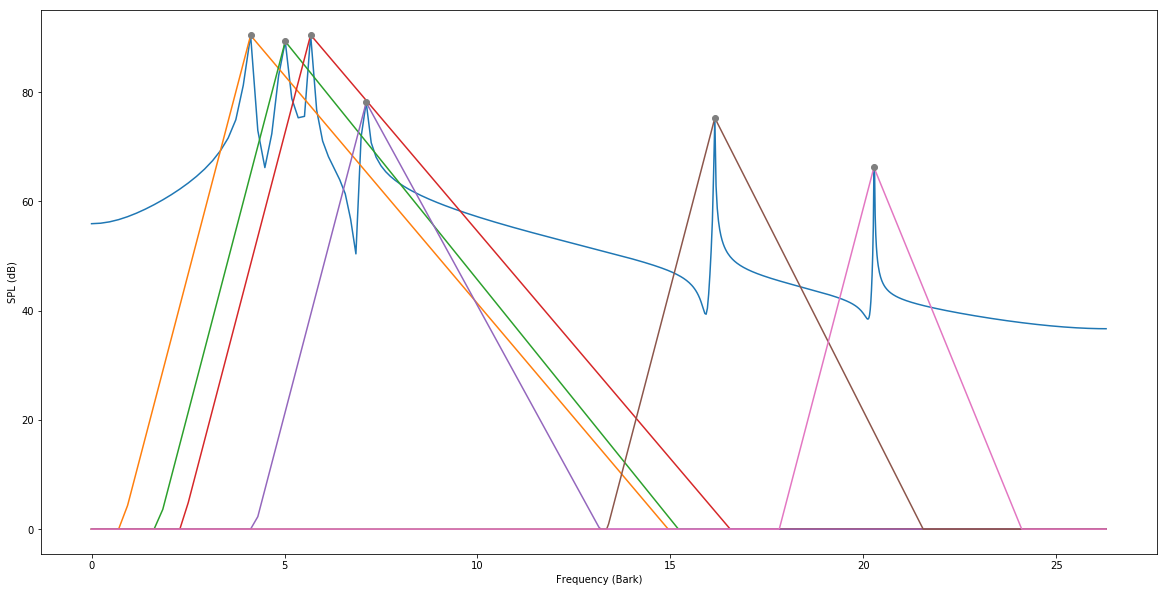

In [9]:
# Desconsiderando o delta

print('Down-shift = 0 dB: ')

plt.figure(figsize=(20,10))
plt.plot(bark, SPL)


for i in peaks:

    plt.plot(bark, sf_peaks_1[i])
    
    
plt.plot(bark[peaks], SPL[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

Down-shift = 16 dB: 


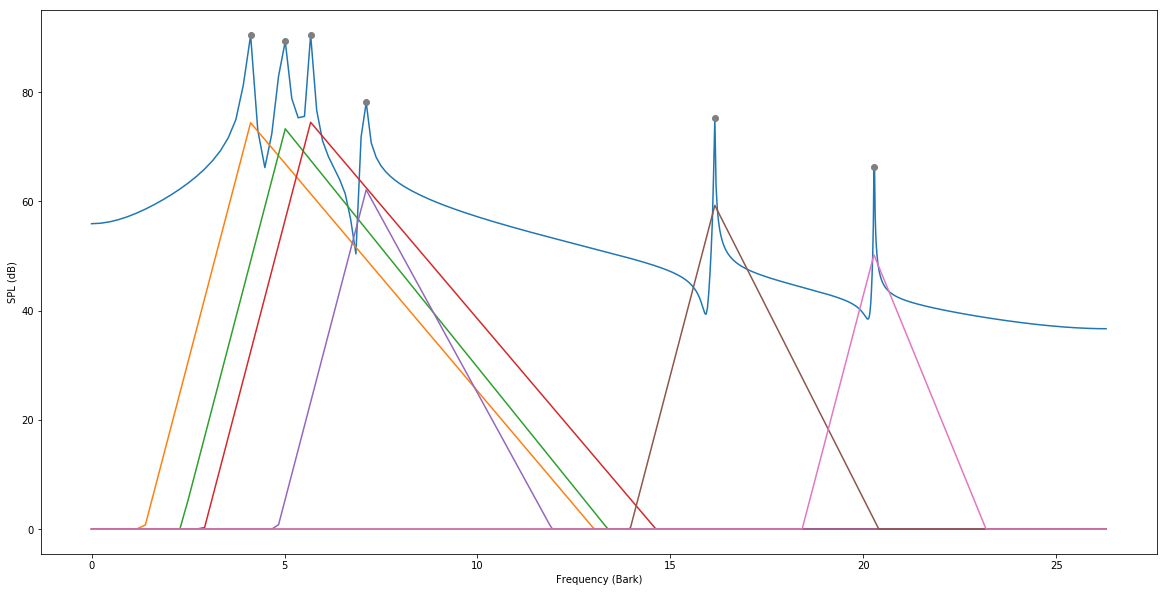

In [10]:
# Considerando delta = 16 dB

print('Down-shift = 16 dB: ')

plt.figure(figsize=(20,10))
plt.plot(bark, SPL)


for i in peaks:

    plt.plot(bark, sf_peaks_2[i])
    
    
plt.plot(bark[peaks], SPL[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

In [11]:
# Considerando alfa tendendo a infinito,
# nossa curva de mascaramento eh definida
# pelas spreading functions de maior valor de cada ponto

def mask_curve(bark, sf_peaks):
    
    mask = np.zeros((len(bark)))
    
    for i in range(len(bark)):
        
        mask[i] = np.amax(sf_peaks[:,i])
        
    return mask

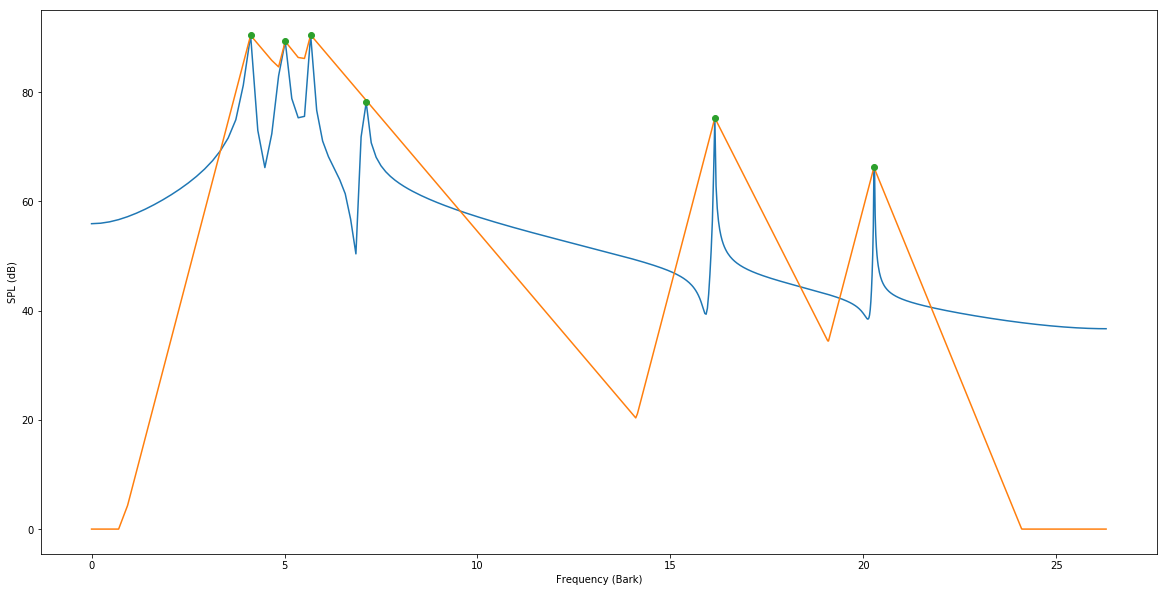

In [12]:
mask_1 = mask_curve(bark, sf_peaks_1)

plt.figure(figsize=(20,10))
plt.plot(bark, SPL)
plt.plot(bark, mask_1)
plt.plot(bark[peaks], SPL[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

In [13]:
# Como pode ser observado no grafico acima,
# algumas das frequencias serao mascaradas
# pelas frequencias de intensidade maior

non_masked_1 = []
masked_1 = []


for i in peaks:
    
    if SPL[i] >= mask_1[i]:
        
        non_masked_1.append(bark2freq(bark[i]))
        
    else:
        
        masked_1.append(bark2freq(bark[i]))
        
print('Frequências mascaradas: ', np.round(masked_1, 1))
print('Frequências não mascaradas: ', np.round(non_masked_1, 1))

Frequências mascaradas:  [890.6]
Frequências não mascaradas:  [ 445.3  562.5  656.2 4406.2 8789.1]


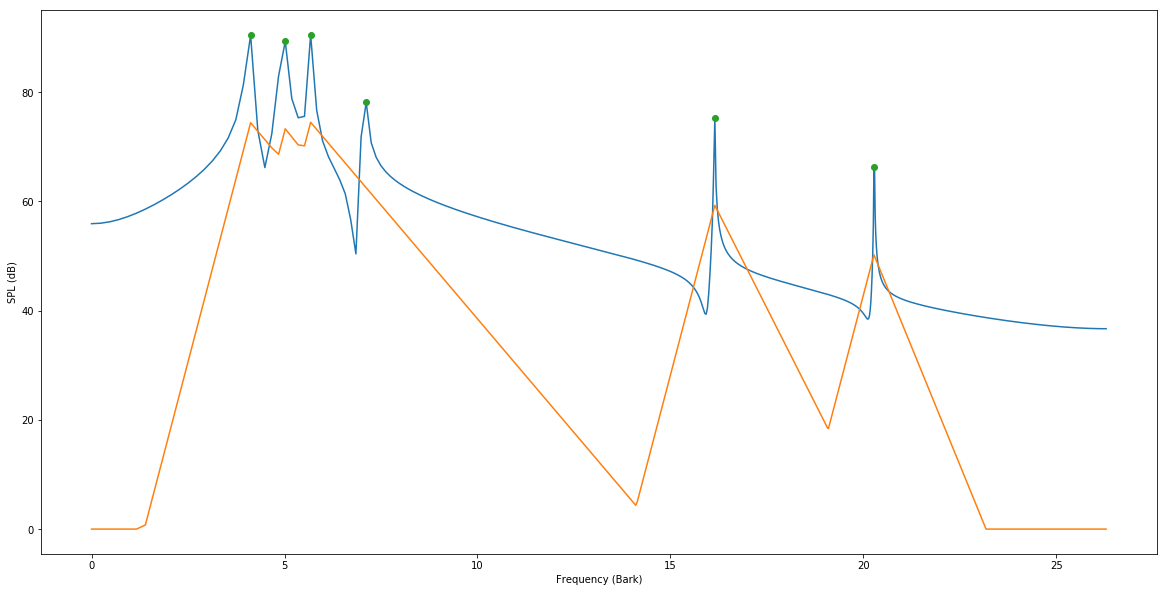

In [14]:
mask_2 = mask_curve(bark, sf_peaks_2)

plt.figure(figsize=(20,10))
plt.plot(bark, SPL)
plt.plot(bark, mask_2)
plt.plot(bark[peaks], SPL[peaks], marker ='o', ls='')
plt.ylabel('SPL (dB)')
plt.xlabel('Frequency (Bark)')
plt.show()

In [15]:
# Como pode ser observado no grafico acima,
# algumas das frequencias serao mascaradas
# pelas frequencias de intensidade maior

non_masked_2 = []
masked_2 = []


for i in peaks:
    
    if SPL[i] >= mask_2[i]:
        
        non_masked_2.append(bark2freq(bark[i]))
        
    else:
        
        masked_2.append(bark2freq(bark[i]))
        
print('Frequências mascaradas: ', np.round(masked_2, 1))
print('Frequências não mascaradas: ', np.round(non_masked_2, 1))

Frequências mascaradas:  []
Frequências não mascaradas:  [ 445.3  562.5  656.2  890.6 4406.2 8789.1]
